# TMA Capacitor Bank discharge vs. current draw profiles

# SITCOM-1224

**title**: TMA (Telescope Mount Assembly) Capacitor Bank discharge vs. current draw profiles

**Description**: Continue in the analysis started in SITCOM-1146 (https://jira.lsstcorp.org/browse/SITCOM-1146). 
This ticket for looking at the relationship between the current draw (rather than power supply voltage) 
and also how much power was in the banks prior to a large drop. This was explored a bit in SITCOM-1146, but could be expanded.

**Author**: Laura Toribio San Cipriano

2024-03-13

### Setup

In [20]:
%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from lsst_efd_client import EfdClient, resample
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState

from astropy.time import Time, TimeDelta
from astropy.table import Table
from scipy.interpolate import UnivariateSpline

In [5]:
client = EfdClient('usdf_efd')

In [6]:
tma_power_topic = 'lsst.sal.MTMount.mainPowerSupply'
tma_el_topic = 'lsst.sal.MTMount.elevation'
tma_az_topic = 'lsst.sal.MTMount.azimuth'

### Get Data

Select, following the format, the night or nights you want to analyze and include them in obs_days.

In [7]:
obs_days = [20240301]#, 20240302, 20240303, 20240304, 20240305]

In [8]:
def get_events(dayObs):
    """
    Identify slew events for a given dayObs
    """
    eventMaker = TMAEventMaker()
    events = eventMaker.getEvents(dayObs)
    
    # Get lists of slew and track events
    slews = [e for e in events if e.type == TMAState.SLEWING]
    tracks = [e for e in events if e.type == TMAState.TRACKING]
    print(f"{dayObs}: Found {len(slews)} slews and {len(tracks)} tracks")
    return slews

In [9]:
def get_acc_jerk(time, velocity):
    """
    From velocity data, calculate acceleration and jerk
    """
    try:
       smoothing_factor=0.2
       kernel_size = 5
       kernel = np.ones(kernel_size) / kernel_size
    
       VelSpline = UnivariateSpline(time, velocity, s=0)
       smoothedVel = np.convolve(VelSpline(time), kernel, mode='same')
       VelSpline = UnivariateSpline(time, smoothedVel, s=smoothing_factor)
    
       AccSpline = VelSpline.derivative(n=1)
       smoothedAcc = np.convolve(AccSpline(time), kernel, mode='same')
       AccSpline = UnivariateSpline(time, smoothedAcc, s=smoothing_factor)
   
       JerkSpline = AccSpline.derivative(n=1) 

       return VelSpline(time), AccSpline(time), JerkSpline(time)
    except:
        return False, False, False

In [10]:
async def data_per_slew(i, slew, debug=False):
    """
    get TMA velocity data, power data for a given slew and e currren draw

    Calculate maximum velocity, acceleration and jerk values and minimum power draw
    """
    data = [i, slew.dayObs, slew.duration, slew.begin, slew.end]

    power_df = await client.select_time_series(tma_power_topic, '*', slew.begin, slew.end)
    
    data.append(np.min(power_df.powerSupplyVoltage))
    data.append(np.max(power_df.powerSupplyCurrent))
    #charge = np.trapz(power_df.powerSupplyCurrent)
    energy_total = np.trapz(power_df.powerSupplyCurrent * power_df.powerSupplyVoltage)
    data.append(energy_total)
    
    az = await client.select_time_series(tma_az_topic, ['*'], slew.begin, slew.end)
    el = await client.select_time_series(tma_el_topic, ['*'], slew.begin, slew.end)
   
    AzBegin = az.actualPosition.iloc[0]
    AzEnd   = az.actualPosition.iloc[-1]
    ElBegin = el.actualPosition.iloc[0]
    ElEnd   = el.actualPosition.iloc[-1]
    
    AzVel, AzAcc, AzJerk = get_acc_jerk(az.timestamp, az.actualVelocity)
    ElVel, ElAcc, ElJerk = get_acc_jerk(el.timestamp, el.actualVelocity)

    for var in [AzVel, AzAcc, AzJerk, ElVel, ElAcc, ElJerk, AzBegin, AzEnd, ElBegin, ElEnd]:
        data.append(np.max(np.abs(var)))
    if debug:
        return az, el, power_df, data
    else:
        return data

In [11]:
Data = []
failed = []
data_names = ['slew_id', 'dayobs', 'duration', 'begin', 'end', 'min_power', 'max_current', 'energy_total', \
              'az_max_vel', 'az_max_acc', 'az_max_jerk', 'el_max_vel', 'el_max_acc', 'el_max_jerk', \
              'az_pos_begin', 'az_pos_end', 'el_pos_begin', 'el_pos_end'] 
for dayObs in obs_days:
    try:
        slews = get_events(dayObs)
    except:
        print(dayObs)
    for i, slew in enumerate(slews):
        try:
            d = await data_per_slew(i, slew)
            Data.append(d)
        except Exception as e:
            failed.append(i)
            #print(i, e)
df = pd.DataFrame(np.vstack(Data),columns=data_names)


20240301: Found 375 slews and 350 tracks


In [12]:
#Remove extreme outliers
df = df[(df.el_max_jerk < 100)&(df.duration<3000)]

### Analysis

#### Relationship of max power supply Current draw and distance of slew

The `plot_spc_vs_dist` function performs a statistical analysis of how the maximum supply power current behaves during the slews. 

It provides histograms of the movements in azimuth and elevation, a histogram of the maximum supply power current, and how the maximum supply power currents are distributed based on the distance of the slews (in azimuth and elevation).

You can save the figures in .png of the function `plot_spc_vs_dist` if you wish. To do this you have to uncomment the last `line plt.savefig(f'{name}.png')`. Otherwise, the figures will appear online

In [12]:
def plot_spc_vs_dist(df_, title_date, name):
    fig, (ax1) = plt.subplots(figsize=(8, 4))

    # Scatter plot of slew distances vs. min_power
    ax1.plot((df_.az_pos_begin - df_.az_pos_end), df_.max_current, 'x', color='C0', label='az')
    ax1.plot((df_.el_pos_begin - df_.el_pos_end), df_.max_current, 'x',  alpha=0.7, color='C1', label='el')
    #ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    ax1.set_xlabel('Slew distances (az/el)')
    ax1.set_ylabel('max supplyPowerCurrent (A)')
    ax1.set_title(f'Max. TMA current vs. distance of slew for {title_date}')

    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 4))
    # Histogram of absolute values of position differences
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, color='C0', label='az')
    ax2.hist(df_.el_pos_begin - df_.el_pos_end, color='C1', alpha=0.7, label='el')
    ax2.legend()
    ax2.set_xlabel('Slew distances (az/el)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Slew distance Histogram for {title_date}')
    
    # Histogram of min_power
    ax3.hist(df_.max_current, bins=50, color='C0', edgecolor='black', alpha=0.5)
    #ax3.axvline(575, ls='--', c='k', label='voltage drop limit')
    ax3.legend()
    ax3.set_xlabel('max supplyPowerCurrent (A)')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'Max. TMA current histogram for {title_date}')
    
    plt.tight_layout()
    plt.show()
    #plt.savefig(f'{name}.png')

In [13]:
for dayObs in np.unique(df.dayobs):
    df_ = df[df.dayobs == dayObs]
    plot_spc_vs_dist(df_, dayObs, f'tma_perf_1-{dayObs}')

#### Look at Azimuth acceleration vs. power supply current

The `plots_spc_vs_ax` function analyzes the behavior of the maximum supply power current and the maximum of velocity, acceleration, and jerk in each slew.

You can save the figures in .png of the function `plots_spc_vs_ax` if you wish. To do this you have to uncomment the last `line plt.savefig(f'{name}.png')`. Otherwise, the figures will appear online.

In [ ]:
def plots_spc_vs_az(df_, title_date,name):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(12, 4))

    ax1.plot(df_.az_max_vel, df_.max_current,'x',label='azVel')
    #ax1.plot(df_.el_max_vel, df_.min_power,'x', label='elVel')
    #ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    #ax1.set_xlim(-1,12)
    ax1.set_xlabel('max Velocity (m/s)')
    ax1.set_ylabel('max supplyPowerCurrent (A)')

    ax2.plot(df_.az_max_acc, df_.max_current,'x',label='azAcc')
    #ax2.plot(df_.el_max_acc, df_.min_power,'x',label='elAcc')
    #ax2.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax2.legend()
    #ax2.set_xlim(-1,25)
    ax2.set_xlabel('max Acceleration $(m/s^{2})$')
    #ax2.set_ylabel('min supplyPowerVoltage (V)')
               
    ax3.plot(df_.az_max_jerk, df_.max_current,'x',label='azSlewDis')
    #ax3.plot(df_.el_max_jerk, df_.min_power,'x', label='elJerk')
    #ax3.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax3.legend()
    #ax3.set_xlim(-100,800)
    ax3.set_xlabel('max Jerk $(m/s^{3})$')
    #ax3.set_ylabel('min supplyPowerVoltage (V)')
               
    fig.suptitle(f'Max. TMA current vs. TMA Performance for {title_date}')
    fig.tight_layout()
    #plt.savefig(f'{name}.png')

In [ ]:
for dayObs in np.unique(df.dayobs):
    df_ = df[df.
    dayobs == dayObs]
    plots_spc_vs_az(df_, dayObs,f'tma_perf_{dayObs}')


#### Look at Azimuth acceleration vs. Total Discharged Energy

The `plots_charge_vs_az` function analyzes the behavior of the total discharged Energy and the maximum of velocity, acceleration, and jerk in each slew.

You can save the figures in .png of the function `plots_charge_vs_az` if you wish. To do this you have to uncomment the last `line plt.savefig(f'{name}.png')`. Otherwise, the figures will appear online.

In [22]:
def plots_energy_vs_az(df_, title_date,name):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(12, 4))

    ax1.plot(df_.az_max_vel, df_.energy_total,'x',label='azVel')
    #ax1.plot(df_.el_max_vel, df_.min_power,'x', label='elVel')
    #ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    #ax1.set_xlim(-1,12)
    ax1.set_xlabel('max Velocity (m/s)')
    ax1.set_ylabel('Total Discharged Energy (J)')

    ax2.plot(df_.az_max_acc, df_.energy_total,'x',label='azAcc')
    #ax2.plot(df_.el_max_acc, df_.min_power,'x',label='elAcc')
    #ax2.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax2.legend()
    #ax2.set_xlim(-1,25)
    ax2.set_xlabel('max Acceleration $(m/s^{2})$')
    #ax2.set_ylabel('min supplyPowerVoltage (V)')
               
    ax3.plot(df_.az_max_jerk, df_.energy_total,'x',label='azSlewDis')
    #ax3.plot(df_.el_max_jerk, df_.min_power,'x', label='elJerk')
    #ax3.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax3.legend()
    #ax3.set_xlim(-100,800)
    ax3.set_xlabel('max Jerk $(m/s^{3})$')
    #ax3.set_ylabel('min supplyPowerVoltage (V)')

    fig.suptitle(f'Total Discharged Energy vs. TMA Performance for {title_date}')
    fig.tight_layout()
    #plt.savefig(f'{name}.png')

In [23]:
def plot_energy_histogram(df_, title_date,name):
    plt.figure(figsize=(8, 6))
    plt.hist(df_.energy_total, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Total Discharged Energy (J)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Total Discharged Energy')
    #plt.savefig(f'{name}_histogram.png')

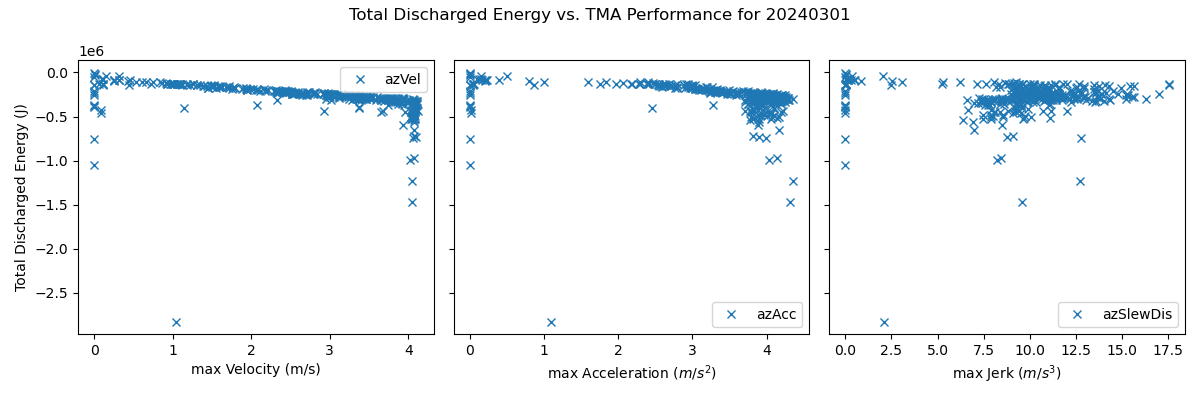

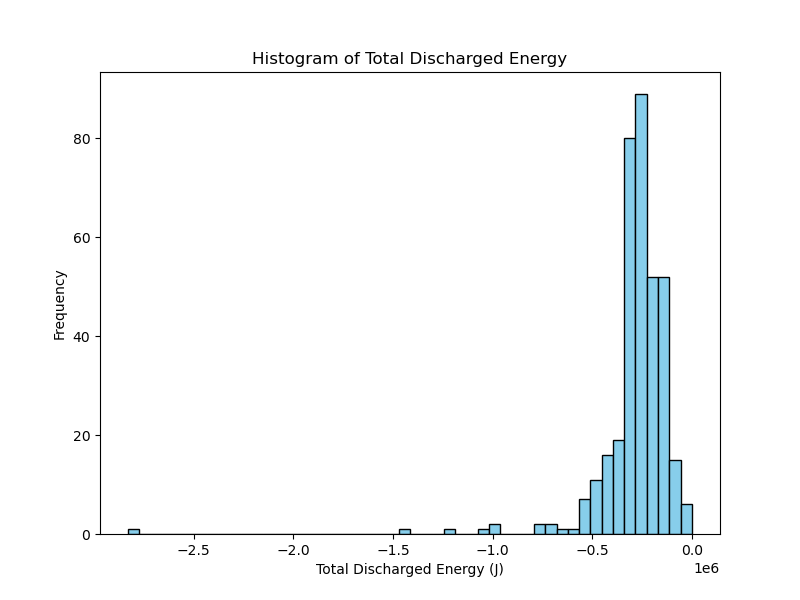

In [24]:
for dayObs in np.unique(df.dayobs):
    df_ = df[df.dayobs == dayObs]
    plots_energy_vs_az(df_, dayObs,f'tma_perf_{dayObs}')
    plot_energy_histogram(df_, dayObs,f'tma_perf_{dayObs}')

### Analysis of Energy (Discharged Energy, Voltage, and Current draw) During Slews

The `plot_vel_charge` function analyzes discaharged energy, voltage, and current consumption over the azimuth velocity, acceleration, and jerk during each slew. 

The discarged energy is calculated as the integral of the current * voltage up to that moment in time. 

The graphs for each night are saved in a folder named `tma_perf_ObsDay`, where `ObsDay` corresponds to the observation night's date. Each figure indicates the corresponding slew number.


In [39]:
def plot_vel_charge(df_, title_date, name, slew, folder_name, az, el):
    try:
        voltage = df_.powerSupplyVoltage
        current = df_.powerSupplyCurrent

        # Convert the index to datetime type
        voltage.index = pd.to_datetime(voltage.index)
        current.index = pd.to_datetime(current.index)

        # Initialize arrays to store integrated charge values
        Discharged_Energy = np.zeros(len(current))

        # Calculate the integrated charge progressively
        for i in range(len(current)):
            Discharged_Energy[i] = np.trapz(current[:i + 1] * voltage[:i + 1])

        AzVel, AzAcc, AzJerk = get_acc_jerk(az.timestamp, az.actualVelocity)
        ElVel, ElAcc, ElJerk = get_acc_jerk(el.timestamp, el.actualVelocity)

        # Check if AzVel, AzAcc, and AzJerk are empty
        if not AzVel.any() or not AzAcc.any() or not AzJerk.any():
            print(f"No data available for azimuth plots for slew {slew.seqNum}")
            return

        # Create artificial time vectors
        AzTime = np.arange(len(AzVel))  # Assuming data occurs at fixed time intervals

        charge_tick = np.arange(len(Discharged_Energy))
        # Calculate scaling factor for charge_tick
        charge_scale_factor = len(AzTime) / len(charge_tick)
        # Scale charge_tick
        charge_tick_scaled = charge_tick * charge_scale_factor

        # Create the plot with nine subplots in a 3x3 grid
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        
        # Plot AzVel
        axs[0,0].plot(AzTime, AzVel, linestyle='-', color='b')
        axs[0,0].set_xlabel('Time (s)')
        axs[0,0].set_ylabel('Velocity (deg/s)')
        axs[0,0].set_title(f'Azimuth Velocity for the slew {slew.seqNum}')
        # Adjusting the y-axis scale of AxVel
        axs[0,0].set_ylim(min(AzVel)- 0.1 * abs(min(AzVel)), max(AzVel)+ 0.1 * abs(max(AzVel)))


        # Plot charge on the same axis as velocity
        ax1_charge = axs[0,0].twinx()
        ax1_charge.plot(charge_tick_scaled, Discharged_Energy, linestyle='-', color='r')
        ax1_charge.set_ylabel('Discharged_Energy (J)', color='r')
        ax1_charge.tick_params(axis='y', colors='r')

        # Plot AzAcc
        axs[0,1].plot(AzTime, AzAcc, linestyle='-', color='b')
        axs[0,1].set_xlabel('Time (s)')
        axs[0,1].set_ylabel('Acceleration (deg/s^2)')
        axs[0,1].set_title(f'Azimuth Acceleration for the slew {slew.seqNum}')

        # Plot charge on the same axis as acceleration
        ax2_charge = axs[0,1].twinx()
        ax2_charge.plot(charge_tick_scaled, Discharged_Energy, linestyle='-', color='r')
        ax2_charge.set_ylabel('Discharged_Energy (J)', color='r')
        ax2_charge.tick_params(axis='y', colors='r')

        # Plot AzJerk
        axs[0,2].plot(AzTime, AzJerk, linestyle='-', color='b')
        axs[0,2].set_xlabel('Time (s)')
        axs[0,2].set_ylabel('Jerk (deg/s^3)')
        axs[0,2].set_title(f'Azimuth Jerk for the slew {slew.seqNum}')

        # Plot charge on the same axis as jerk
        ax3_charge = axs[0,2].twinx()
        ax3_charge.plot(charge_tick_scaled, Discharged_Energy, linestyle='-', color='r')
        ax3_charge.set_ylabel('Discharged_Energy (J)', color='r')
        ax3_charge.tick_params(axis='y', colors='r')       

       
        ###### VOLTAGE #######
        # Plot AzVel
        axs[1,0].plot(AzTime, AzVel, linestyle='-', color='b')
        axs[1,0].set_xlabel('Time (s)')
        axs[1,0].set_ylabel('Velocity (deg/s)')
        axs[1,0].set_title(f'Azimuth Velocity for the slew {slew.seqNum}')
        # Adjusting the y-axis scale of AxVel
        axs[1,0].set_ylim(min(AzVel)- 0.1 * abs(min(AzVel)), max(AzVel)+ 0.1 * abs(max(AzVel)))
        
        # Plot charge on the same axis as velocity
        ax1_voltage = axs[1,0].twinx()
        ax1_voltage.plot(charge_tick_scaled, voltage.values, linestyle='-', color='g')
        ax1_voltage.set_ylabel('supplyPowerVoltage (V)', color='g')
        ax1_voltage.tick_params(axis='y', colors='g')

        # Plot AzAcc
        axs[1,1].plot(AzTime, AzAcc, linestyle='-', color='b')
        axs[1,1].set_xlabel('Time (s)')
        axs[1,1].set_ylabel('Acceleration (deg/s^2)')
        axs[1,1].set_title(f'Azimuth Acceleration for the slew {slew.seqNum}')

        # Plot charge on the same axis as acceleration
        ax2_voltage = axs[1,1].twinx()
        ax2_voltage.plot(charge_tick_scaled, voltage.values, linestyle='-', color='g')
        ax2_voltage.set_ylabel('supplyPowerVoltage (V)', color='g')
        ax2_voltage.tick_params(axis='y', colors='g')

        # Plot AzJerk
        axs[1,2].plot(AzTime, AzJerk, linestyle='-', color='b')
        axs[1,2].set_xlabel('Time (s)')
        axs[1,2].set_ylabel('Jerk (deg/s^3)')
        axs[1,2].set_title(f'Azimuth Jerk for the slew {slew.seqNum}')

        # Plot charge on the same axis as jerk
        ax3_voltage = axs[1,2].twinx()
        ax3_voltage.plot(charge_tick_scaled, voltage.values, linestyle='-', color='g')
        ax3_voltage.set_ylabel('supplyPowerVoltage (V)', color='g')
        ax3_voltage.tick_params(axis='y', colors='g')
        

        ##### CURRENT DRAW #########
        # Plot AzVel
        axs[2,0].plot(AzTime, AzVel, linestyle='-', color='b')
        axs[2,0].set_xlabel('Time (s)')
        axs[2,0].set_ylabel('Velocity (deg/s)')
        axs[2,0].set_title(f'Azimuth Velocity for the slew {slew.seqNum}')
        # Adjusting the y-axis scale of AxVel
        axs[2,0].set_ylim(min(AzVel)- 0.1 * abs(min(AzVel)), max(AzVel)+ 0.1 * abs(max(AzVel)))
        
        # Plot charge on the same axis as velocity
        ax1_current = axs[2,0].twinx()
        ax1_current.plot(charge_tick_scaled, current.values, linestyle='-', color='orange')
        ax1_current.set_ylabel('supplyPowerCurrent (A)', color='orange')
        ax1_current.tick_params(axis='y', colors='orange')

        # Plot AzAcc
        axs[2,1].plot(AzTime, AzAcc, linestyle='-', color='b')
        axs[2,1].set_xlabel('Time (s)')
        axs[2,1].set_ylabel('Acceleration (deg/s^2)')
        axs[2,1].set_title(f'Azimuth Acceleration for the slew {slew.seqNum}')

        # Plot charge on the same axis as acceleration
        ax1_current = axs[2,1].twinx()
        ax1_current.plot(charge_tick_scaled, current.values, linestyle='-', color='orange')
        ax1_current.set_ylabel('supplyPowerCurrent (A)', color='orange')
        ax1_current.tick_params(axis='y', colors='orange')
        
        # Plot AzJerk
        axs[2,2].plot(AzTime, AzJerk, linestyle='-', color='b')
        axs[2,2].set_xlabel('Time (s)')
        axs[2,2].set_ylabel('Jerk (deg/s^3)')
        axs[2,2].set_title(f'Azimuth Jerk for the slew {slew.seqNum}')

        # Plot charge on the same axis as jerk
        ax1_current = axs[2,2].twinx()
        ax1_current.plot(charge_tick_scaled, current.values, linestyle='-', color='orange')
        ax1_current.set_ylabel('supplyPowerCurrent (A)', color='orange')
        ax1_current.tick_params(axis='y', colors='orange')
        
        plt.tight_layout()
        plt.show()

        # Save the image with all plots
        fig.savefig(os.path.join(folder_name, f'{name}_azimuth_plots.png'))

        # Close the figure to release memory
        plt.close(fig)

    except AttributeError:
        pass


20240301: Found 375 slews and 350 tracks


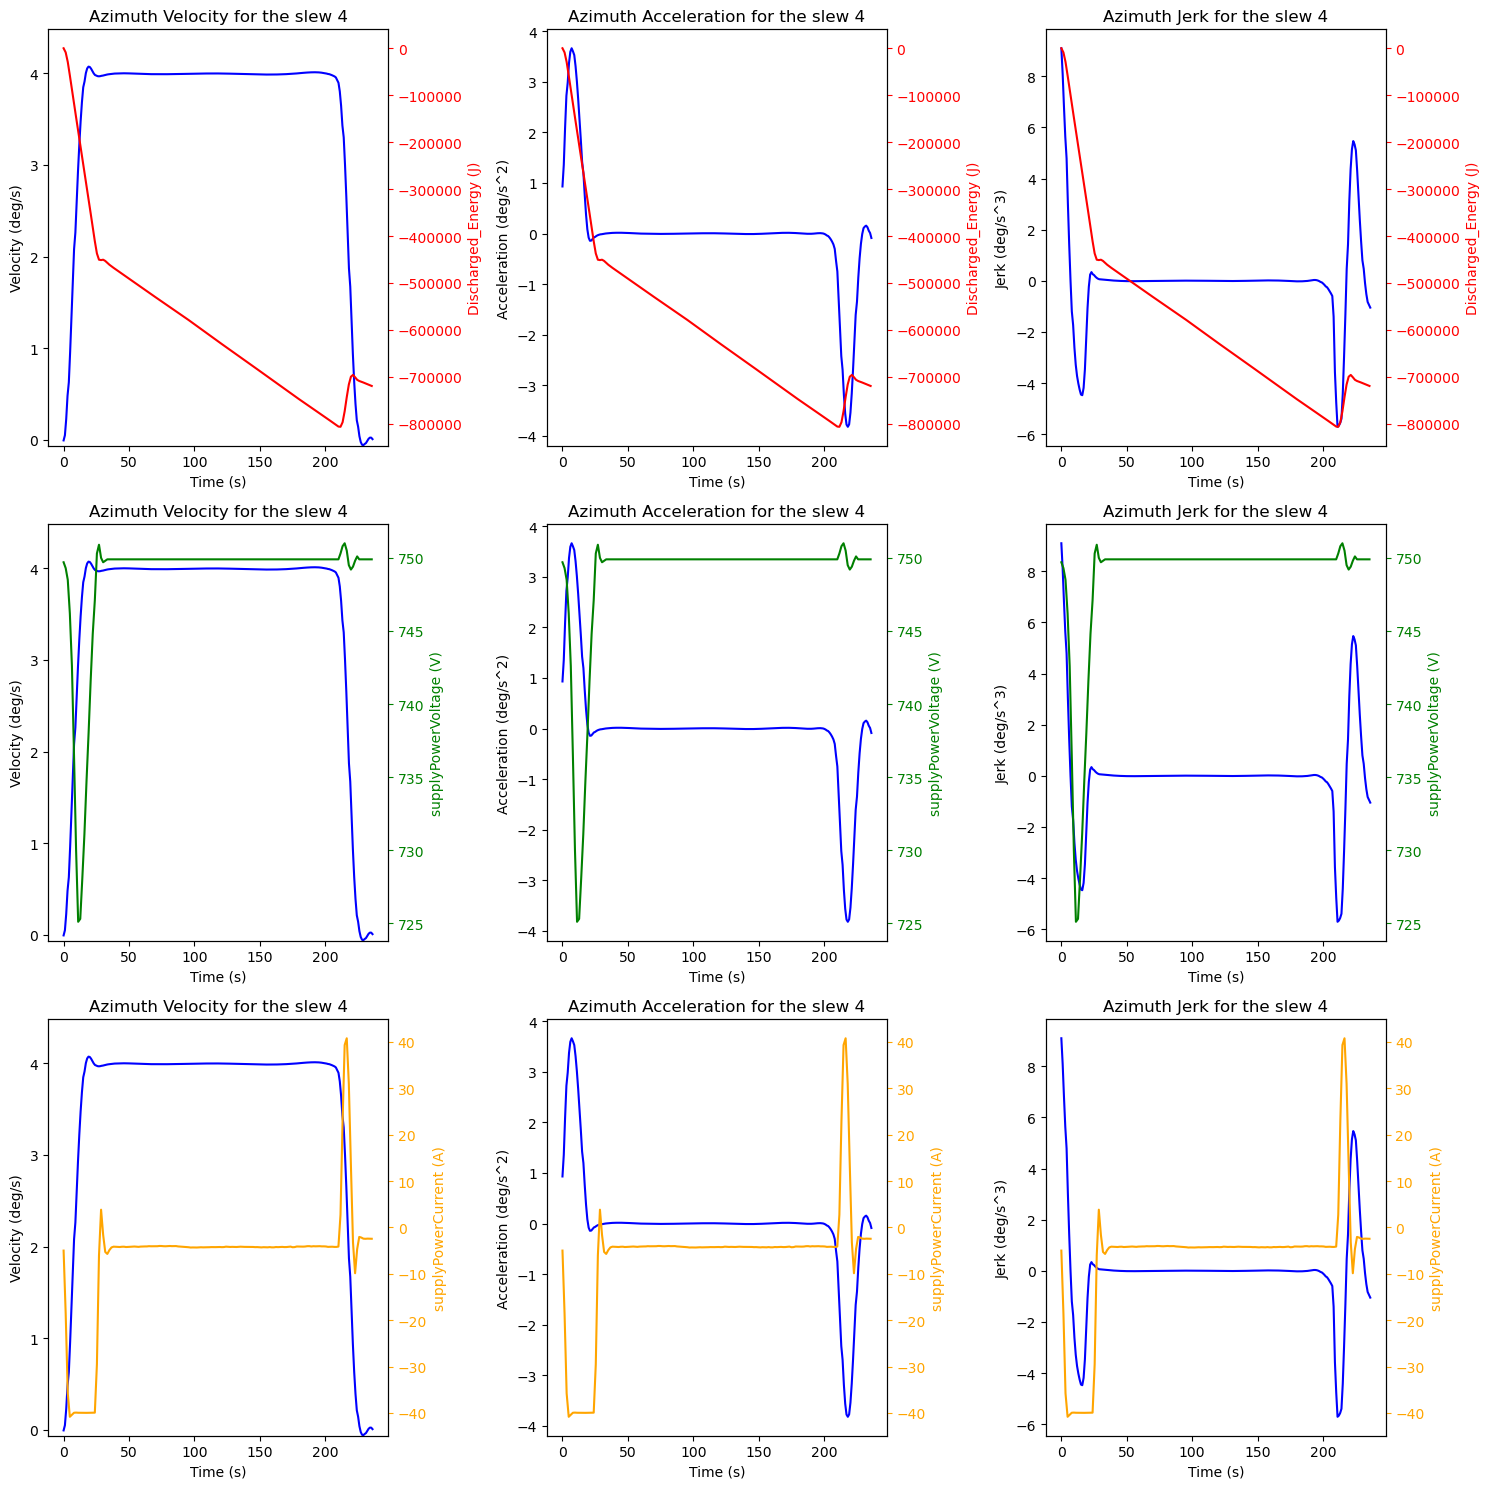

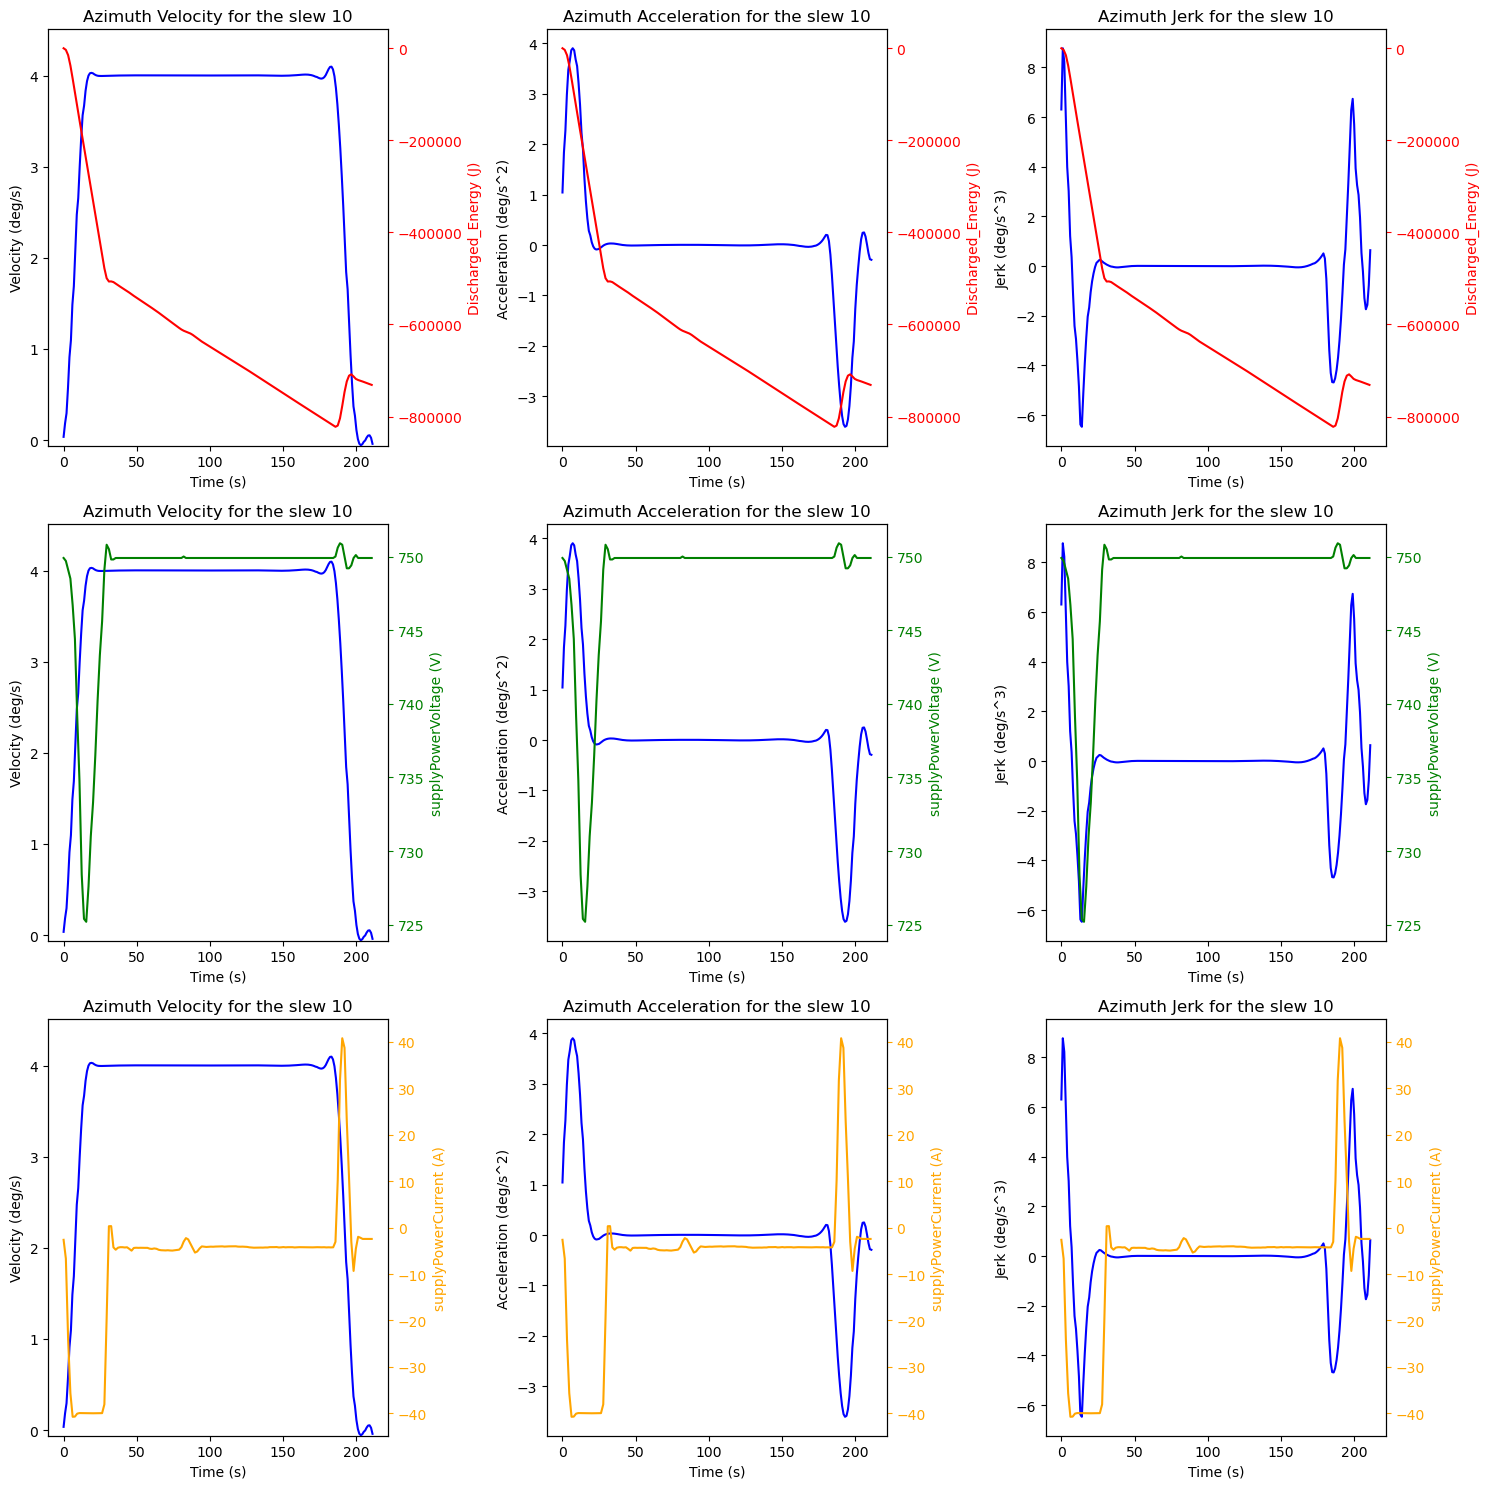

In [40]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

for dayObs in np.unique(df.dayobs):
    try:
        # Crear el nombre de la carpeta
        folder_name = os.path.join(os.getcwd(), f"tma_perf_{dayObs}")
        
        # Crear la carpeta para la fecha si no existe
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        
        slews = get_events(dayObs)
        
        for i, slew in enumerate(slews):
           # The if select some cases so as not to show all of them. If you want to show all of them, just comment on the following 4 lines
            if i < 2:
                continue
            if i > 7:
                break
                
            power_df = await client.select_time_series(tma_power_topic, '*', slew.begin, slew.end)
            az = await client.select_time_series(tma_az_topic, ['*'], slew.begin, slew.end)
            el = await client.select_time_series(tma_el_topic, ['*'], slew.begin, slew.end)            
                #data.append(power_df)

            plot_vel_charge(power_df, dayObs, f'tma_perf_{dayObs}_{slew.seqNum}', slew, folder_name, az, el)
            
    except Exception as e:
        print("Error:", e)
        print(dayObs)

### TEST

#### Analyse the voltage and the current draw during the slew

In [ ]:
def plot_voltage(df_, title_date, name, slew, folder_name):
    try:
        voltage = df_.powerSupplyVoltage
    
        # Convert the index to datetime type
        voltage.index = pd.to_datetime(voltage.index)
        
        # Check if the voltage is constant
        if len(set(voltage.values)) == 1:
            print(f"The slew {slew.seqNum} has constant voltage")
            return

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(voltage.index, voltage.values, linestyle='-')
        ax.set_title(f'supplyPowerVoltage (V) for the slew {slew.seqNum}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('supplyPowerVoltage (V)')

        ax.tick_params(axis='x', rotation=45)

        # Set x-axis limits
        #ax.set_xlim(0, (voltage.index[-1] - voltage.index[0]).total_seconds())

        fig.tight_layout()

        # Save images
        plt.savefig(os.path.join(folder_name, f'{name}_voltage.png'))

        # Close the figure to release memory
        plt.close()
        
    except AttributeError:
        pass


In [ ]:
import os

for dayObs in np.unique(df.dayobs):
    try:
        # Create folder to save the plots
        folder_name = os.path.join(os.getcwd(), f"tma_perf_{dayObs}_voltage")
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        
        slews = get_events(dayObs)
        
        for i, slew in enumerate(slews):
            #data = [i, slew.dayObs, slew.duration, slew.begin, slew.end]
            power_df = await client.select_time_series(tma_power_topic, '*', slew.begin, slew.end)
            plot_voltage(power_df, dayObs, f'tma_perf_{dayObs}_{slew.seqNum}', slew, folder_name)
            
    except Exception as e:
        print("Error:", e)
        print(dayObs)
